In [1]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# (1) Data understanding and prep:

The original dataset from CDC that was cleaned in the previous homework assignment is now imported as a starting point for this work. 
1. The accompanying data quality report from the previous homework assignment can be found attached as PDF as a background to this cleaned dataset.
2. A summary of this plan can be seen in the table below.
3. In addition a number of extra features were added that were not in the original dataset:
    - **time_dif**: The time delta between the earliest date on record and the reported date of each case for each entry.
    - **elderly**: Yes if the age_group of the person in the entry is 60–69 Years, 70–79 Years, or 80+ Years. No otherwise.
    - **quarter**: If the case occurs in the first quartile of the span of time that cases are recorded, then it is designated as 'first', if the case occurs in the second quartile of the span of time that cases are recorded, then it is designated as 'second', and so on.


### Summary of data quality plan:

**Variable Names**|**Data Quality Issue**|**Handling Strategy**
:-----:|:-----:|:-----:
earliest\_date|logical errors|change value for  the 'earliest\_date' column to the minimum value for the column
report\_date|missing 24.08% of its values.|do nothing
posSpec\_date|missing 72.74% of its values|drop column
onset|missing 49.16 % of its values; imperfect method of data collection|drop column
status|logical errors|remove failed rows
sex|missing 0.82% of its values|remove rows with missing values
age\_group|missing 0.1% of its values|remove rows with missing values
race\_ethnicity|missing 42.54% of its values|do nothing
hosp|missing 41.25% of its values|do nothing
icu|missing 89.35% of its values|drop column
death|none|do nothing
medcond|missing 82.83% of its values|drop column

##  1.1 Review, prepare and split the dataset into two datasets: 70% training and 30% test


### Opening the cleaned CSV file from the previous homework assignment

In [3]:
df = pd.read_csv('covid19-cdc-19200690_cleaned_1_3.csv', index_col=0)

### Printing the shape of the dataframe, the first five rows and the last five rows

In [4]:
df.shape

(9697, 11)

In [5]:
df.head()

,earliest_date,report_date,status,sex,age_group,race_ethnicity,hosp,death,time_dif,elderly,quarter
0,2020-12-16,NaN,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,Unknown,No,NaN,No,fourth
1,2020-11-10,2020-11-13,Laboratory-confirmed case,Male,40 - 49 Years,"White, Non-Hispanic",Missing,No,3 days,No,fourth
2,2020-10-12,2020-10-16,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",No,No,4 days,No,third
3,2021-01-15,2021-01-15,Laboratory-confirmed case,Male,50 - 59 Years,"White, Non-Hispanic",No,No,0 days,No,fourth
4,2021-01-01,NaN,Laboratory-confirmed case,Female,30 - 39 Years,"White, Non-Hispanic",Missing,No,NaN,No,fourth


In [6]:
df.tail()

,earliest_date,report_date,status,sex,age_group,race_ethnicity,hosp,death,time_dif,elderly,quarter
9692,2020-08-10,NaN,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,No,NaN,Yes,third
9693,2020-10-13,2020-10-19,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,No,No,6 days,No,third
9694,2020-08-04,2020-08-04,Laboratory-confirmed case,Female,80+ Years,"Black, Non-Hispanic",No,No,0 days,Yes,third
9695,2020-12-12,NaN,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,Missing,No,NaN,No,fourth
9696,2020-11-14,2020-11-25,Laboratory-confirmed case,Male,50 - 59 Years,"Black, Non-Hispanic",No,No,11 days,No,fourth


### Inspect the datatypes and check for null values

In [7]:
df.dtypes

earliest_date     object
report_date       object
status            object
sex               object
age_group         object
race_ethnicity    object
hosp              object
death             object
time_dif          object
elderly           object
quarter           object
dtype: object

In [8]:
df.isna().sum()

earliest_date        0
report_date       2366
status               0
sex                  0
age_group            0
race_ethnicity       0
hosp                 0
death                0
time_dif          2366
elderly              0
quarter              0
dtype: int64

### Columns will need to be converted to their appropriate data types

- **select the continuous columns, and assign the list of these column names to the variable 'continuous'**

In [9]:
continuous = df[['earliest_date','report_date','time_dif']].columns
continuous

Index(['earliest_date', 'report_date', 'time_dif'], dtype='object')

#### There are 2 types of continuous column: datetime and time delta. Each column needs to be converted to its corresponding type

In [10]:
# datetime
datetime = df[['earliest_date','report_date']].columns
datetime

Index(['earliest_date', 'report_date'], dtype='object')

#### Convert date time columns to type datetime

In [11]:
for date in datetime:
    df[date] = df[date].astype('datetime64')

#### Convert time delta column to type time delta

In [12]:
# timedelta
df['time_dif'] = pd.to_timedelta(df['time_dif'])

In [13]:
df[continuous].dtypes

earliest_date     datetime64[ns]
report_date       datetime64[ns]
time_dif         timedelta64[ns]
dtype: object

#### Select the columns for the categorical table, and assign the list of these column names to the variable 'categorical'

In [14]:
categorical = df[['status','sex','age_group','race_ethnicity','hosp','elderly', 'quarter']].columns
categorical

Index(['status', 'sex', 'age_group', 'race_ethnicity', 'hosp', 'elderly',
       'quarter'],
      dtype='object')

#### Convert each of these features to type 'category'

In [15]:
for col in categorical:
    df[col] = df[col].astype('category')
    
df[categorical].dtypes

status            category
sex               category
age_group         category
race_ethnicity    category
hosp              category
elderly           category
quarter           category
dtype: object

### Convert datatypes for plotting later

We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- The target feature "death" is categorical, with values "Yes" and "No". These will be mapped 'Yes': 1, "No": 0 and stored as "int64".
- The feature "status" is categorical, with values "Laboratory-confirmed Case" and "Probable Case". These will be mapped 'Laboratory-confirmed Case': 1, "Probable Case": 0 and stored as "int64".
- The feature "sex" is categorical, with values "Female" and "Male". These will be mapped 'Female': 1, "Male": 0 and stored as "int64".
- The feature "elderly" is categorical, with values "Yes" and "No". This will be mapped 'Yes': 1, "No": 0 and stored as "int64".

In [16]:
# convert "death" to 0,1
df['death'] = df['death'].map({'Yes': 1, "No": 0})

# convert "status" to 0,1
df['status'] = df['status'].map({'Laboratory-confirmed case': 1, "Probable Case": 0})

# convert "sex" to 0,1
df['sex'] = df['sex'].map({'Female': 1, "Male": 0})

# convert "elderly" to 0,1
df['elderly'] = df['elderly'].map({'Yes': 1, "No": 0})


#### Convert each binary categorical feature to type int64

In [17]:
# convert "death" to int
df['death'] = df['death'].astype('int64')

# convert "status" to int
df['status'] = df['status'].astype('int64')

# convert "sex" to int
df['sex'] = df['sex'].astype('int64')

# convert "elderly" to int
df['elderly'] = df['elderly'].astype('int64')

In [18]:
df.dtypes

earliest_date      datetime64[ns]
report_date        datetime64[ns]
status                      int64
sex                         int64
age_group                category
race_ethnicity           category
hosp                     category
death                       int64
time_dif          timedelta64[ns]
elderly                     int64
quarter                  category
dtype: object

#### Deal with NaT values
NaT that values appear in the "report_date" and "time_dif" features will need to be dealt with before any modeling takes place
- Any feature with a missing value for "report_date" will also have a missing value for "time_dif"
- My proposed solution for this is to make all NaT values in the "report_date" column the same value as the "earliest_date" column for that entry, and make the "time_dif" column value "0 days".
  - Then to account for the missing "report_date" value, I will create a new feature: "missing_report", which will be 1 or 0, indicating True or False.
  
- The other approaches for this, such as performing imputation with the median; inserting a strange value such as an invalid date were decided against, because they would change the values for the 'time_dif' feature, making the feature pointless.
- It was also decided to keep the feature, because without the "report_date" feature, we would also have to drop the "time_dif" feature, which should be explored in relation to the target feature: this way we can see if there is a correlation between an increasing time difference between the case ocurring and being reoprted, and the likelihood of a death; or if there is a correlation between a missing report date and a death.

In [19]:
df['missing_report'] = 0
for i in range(df.shape[0]):
    if pd.isnull(df.loc[i]["report_date"]):
        df.at[i, "missing_report"] = 1

In [20]:
# adapted code from here to change values in a column based on another column in the same dataframe
# https://stackoverflow.com/questions/39903090/efficiently-replace-values-from-a-column-to-another-column-pandas-dataframe
df["report_date"] = np.where(pd.isnull(df["report_date"]), df['earliest_date'], df['report_date'])

# adapted code from here to change values of a column based a specific condition
# https://www.kite.com/python/answers/how-to-change-values-in-a-pandas-dataframe-column-based-on-a-condition-in-python#:~:text=loc%20to%20change%20values%20in,for%20which%20condition%20is%20True%20.
df.loc[pd.isnull(df["time_dif"]), "time_dif"] = "0 days 00:00:00"

df['time_dif'] = pd.to_timedelta(df['time_dif'])


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be "death"
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "death" from the dataframe

In [21]:
y = pd.DataFrame(df["death"])
X = df.drop(["death"],1)

##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [22]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9697
training range (70%):	 rows 0 to 6787
test range (30%): 	 rows 6787 to 9697


The dataset is now ready for plotting

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model

- All plots will be using the training subset of dataset: X_train, y_train
- We won't be plotting correlations of just continuous features, because they are dates. The correlations will all be self-explanatory and will not offer any insights into the data or help with prediction. For example, if an entry has an earliest date of "2020-11-10" and a reported date of "2020-11-13", then the time difference between them will be 3 days. Not much else will be learned from these features alone.
- Instead we will go straight to plotting continuous features against target feature.

### 1.2.1 Plot interaction between continuous features and target feature
- Here we will make plots of each continuous against the target 'death'
- We will discuss what we observe from these plots, e.g. if there are any particular dates that see a larger number of deaths. This could mean that death is more likely to occur at certain times of the year.
- We will choose a subset of continuous features we find promising (if any) and justify our choice.

In [23]:
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

X_train.head()

,earliest_date,report_date,status,sex,age_group,race_ethnicity,hosp,time_dif,elderly,quarter,missing_report
0,2020-11-12,2020-11-12,1,1,30 - 39 Years,Unknown,Unknown,0 days,0,fourth,0
1,2020-08-01,2020-08-01,1,0,60 - 69 Years,Unknown,Missing,0 days,1,third,1
2,2020-12-04,2020-12-07,1,1,80+ Years,Unknown,Missing,3 days,1,fourth,0
3,2020-12-13,2020-12-13,1,1,20 - 29 Years,Unknown,Unknown,0 days,0,fourth,0
4,2021-01-08,2021-01-08,1,1,60 - 69 Years,"Black, Non-Hispanic",Unknown,0 days,1,fourth,0


In [24]:
# plot earliest_date against death
# make a dict with each unique date as a key and a value of 0
# go through the dataframe
# for every entry, increase the value of that entry's 'earliest_date' by 1.
# plot the dict keys against the dict values

df_temp = pd.concat([X_train['earliest_date'], y_train], axis=1)

deathEarDict = {}
dateDict = {}
for i in df_temp['earliest_date'].sort_values():
    dateDict[i] = 0
    deathEarDict[i] = 0
    
for f in range(df_temp.shape[0]):
    dateDict[df_temp.loc[f]['earliest_date']] += 1
    if df_temp.loc[f]['death']==1:
        deathEarDict[df_temp.loc[f]['earliest_date']] += 1

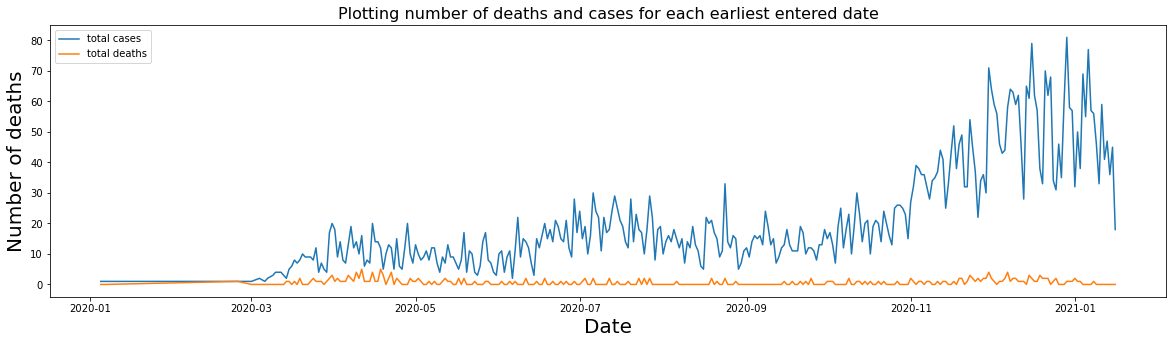

In [25]:
plt.figure(figsize=(20,5))
plt.title("Plotting number of deaths and cases for each earliest entered date", fontsize=16)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of deaths", fontsize=20)
plt.plot(dateDict.keys(), dateDict.values(), label='total cases')
plt.plot(deathEarDict.keys(), deathEarDict.values(), label='total deaths')
plt.legend()

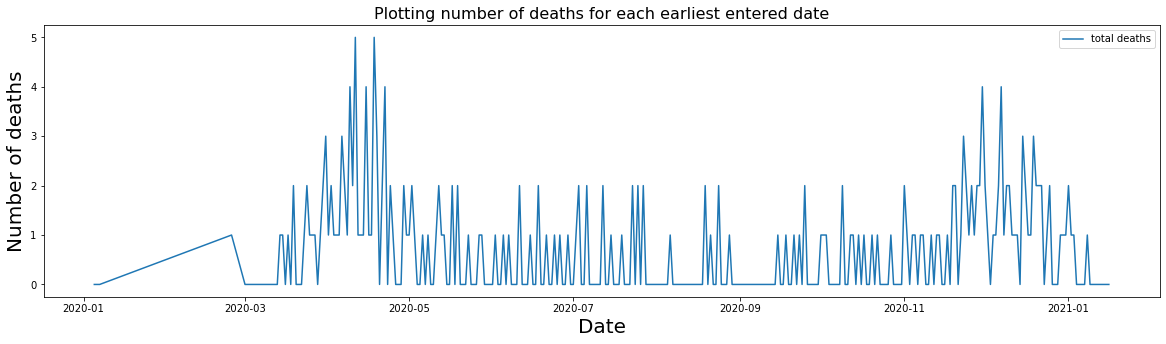

In [26]:
plt.figure(figsize=(20,5))
plt.title("Plotting number of deaths for each earliest entered date", fontsize=16)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of deaths", fontsize=20)
plt.plot(deathEarDict.keys(), deathEarDict.values(), label='total deaths')
plt.legend()

In [27]:
# plot report_date against death
# make a dict with each unique date where the  as a key and a value of 0
# go through the dataframe
# for every entry, increase the value of that entry's 'report_date' by 1.
# plot the dict keys against the dict values
# only store the dates where 'missing_report' is false

df_temp = pd.concat([X_train[['report_date', 'missing_report']], y_train], axis=1)

dateDict = {}
deathRepDict = {}

for i in df_temp['report_date'].sort_values():
    deathRepDict[i] = 0
    dateDict[i] = 0

for i in range(df_temp.shape[0]):
    if df_temp.loc[i]['missing_report']==0:
        dateDict[df_temp.loc[i]['report_date']] += 1
        if df_temp.loc[i]['death']==1:
            deathRepDict[df_temp.loc[i]['report_date']] += 1

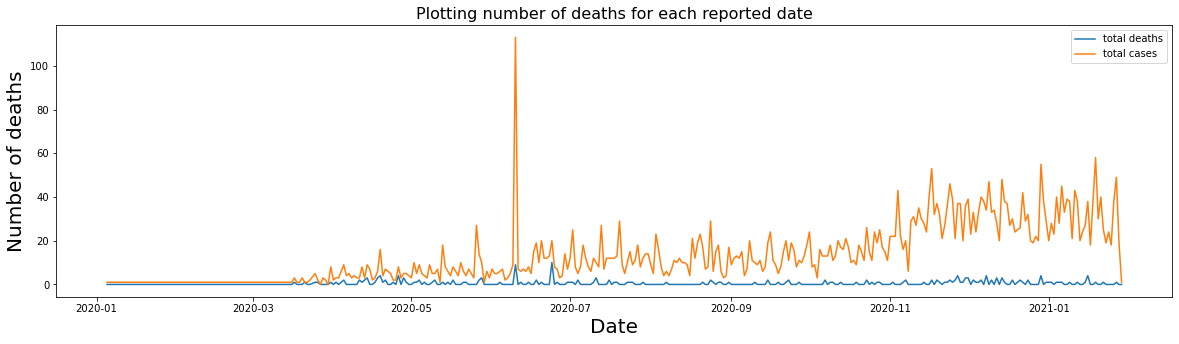

In [28]:
plt.figure(figsize=(20,5))
plt.title("Plotting number of deaths for each reported date", fontsize=16)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of deaths", fontsize=20)
plt.plot(deathRepDict.keys(), deathRepDict.values(), label='total deaths')
plt.plot(dateDict.keys(), dateDict.values(), label='total cases')
plt.legend()

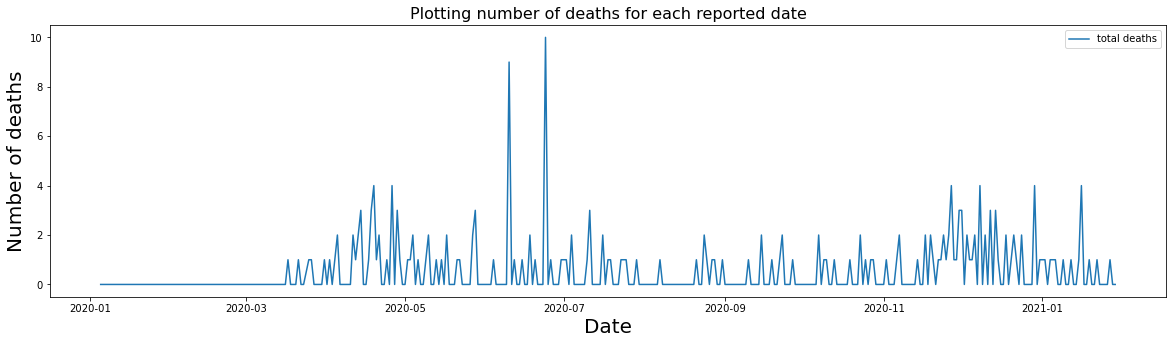

In [29]:
plt.figure(figsize=(20,5))
plt.title("Plotting number of deaths for each reported date", fontsize=16)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of deaths", fontsize=20)
plt.plot(deathRepDict.keys(), deathRepDict.values(), label='total deaths')
plt.legend()

In [30]:
# convert time_dif to int
X_train['time_dif'] = X_train['time_dif'].dt.days.astype('int64')

df_temp = pd.concat([X_train['time_dif'], y_train], axis=1)
df_temp.reset_index(inplace=True, drop=True)

In [31]:
correlation = df_temp.corr()
correlation

,time_dif,death
time_dif,1.000000,0.021371
death,0.021371,1.000000


<AxesSubplot:xlabel='time_dif', ylabel='death'>

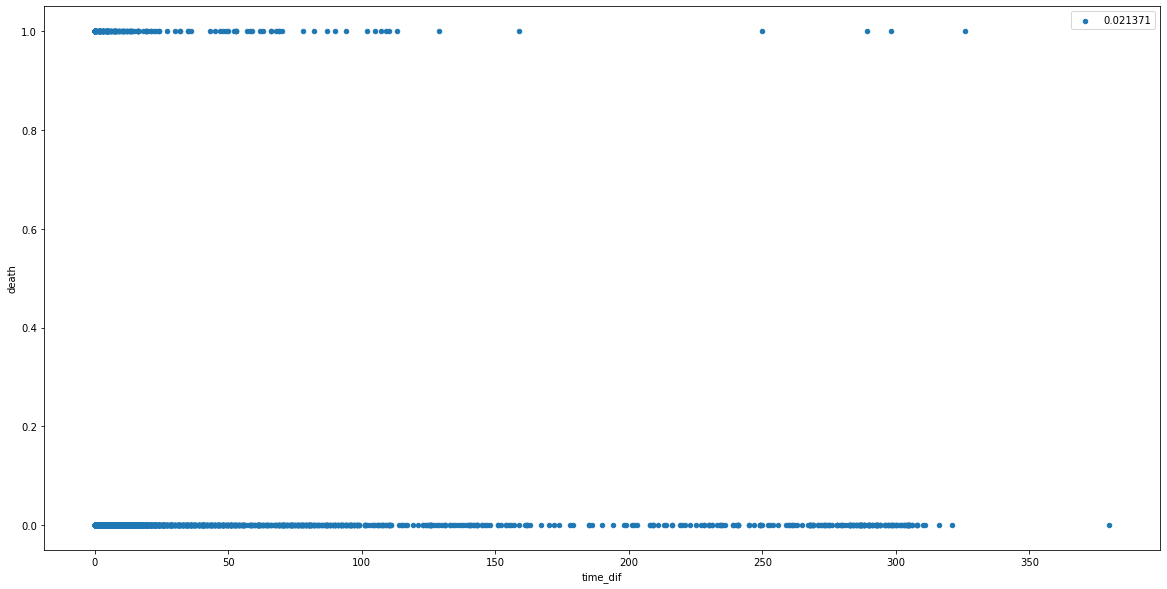

In [32]:
# plot the column and target feature
df_temp.plot(kind='scatter', x="time_dif", y="death", label="0.021371", figsize=(20,10))

#### 1.2.1 Interpretation of the results
- Observing the plots, are there any clear correlations? And is this to be expected with this kind of problem? There are many interactions to take into account.
- Observing each of the plots above, there is no clear correlation for any of the continuous features.
- **'earliest_date'**
    - For this feature I have plotted the total number of entries for each date contrasted with the number of deaths for each date. I have also plotted just the number of deaths for this date to get a closer look at the trends for it. As we can see, the total number of entries increases as time progresses, but the number of deaths does not. In fact, the number of deaths never goes above 5 in one day, and in the later dates of the data – when the total number of cases per day has increased – the number of deaths never goes above 4. 
- **'report_date'**
    - For this feature, I left out any entries where the "missing_report" feature had a value of 1. This meant that any null values that would skew the data could be avoided. 
    - I have plotted the total number of entries for each date contrasted with the number of deaths for each date. I have also plotted just the number of deaths for this date to get a closer look at the trends for it. This feature is more extreme than the pervious one: there are 2 days where 10 deaths are reported. However, this could be indicative of reports being collected in batches.
- **'time_dif'**
    - This feature was the reason I kept in the 'report_date' feature: I wanted to see if there was any correlation between the time difference of a case ocurring and being reported, and a higher likelihood of death. There is no real correlation here:
        - Most of the deaths with a smaller time difference, but so do most of the non-deaths. This indicates to me that most of the cases with a report date have a small difference in the time of its reporting and the time of the case ocurring. The increase in the difference of these times does not seem more likely to lead to a death. <br><br>

- None of the correlations are particularly strong here. There is a chance that by grouping the continuous features into categories – I have done this by grouping the 'earliest_date' feature into quarters – we will see more of a correlation of what period the case occured in with the likelihood of death.<br>
   
#### Actions:
- I will drop the **'report_date'** feature. There is no strong correlation between it and the likelihood of a death that is not already present in the **'earliest_date'** feature, which I will keep. Also the feature was mainly necessary to account for the **'time_dif'** feature, which I will not be keeping.
- I will drop **'time_dif'** feature, as there was no correlation in its increasing amount with the number of deaths reported. 
- I will drop the **'earliest_date'** feature. There is not a strong correlation between it and the number of deaths reported.

**I think that dates are not a relevant predictor of death as the COVID-19 pandemic continues. We have seen in the plots above how the number of deaths was at its peak in April 2020. This is despite the fact that the number of cases was at its peak in December 2020 and January 2021. This indicates to me that hopsitals have adpated to the pandemic and are treating people more effectively now. Thus, just because COVID-19 cases will happen this April it does not mean that there is likely to be more deaths this April.**

### 1.2.2 Plot interaction between categorical features and target feature
- Here we will plot a pairwise interaction between each categorical feature against the target feature. 
- We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature.
- We will choose a subset of categorical features we find promising (if any) and justify our choice.

Here we have 10 categorical features
- 'status', 'sex', 'age_group', 'race_ethnicity', 'hosp', 'time_dif', 'elderly', 'quarter'.
- A plot for each will be created.

##### Create stacked bar plots for all categorical features

- for the comparison, the target feature is converted back to categorical


status
Index 	 Count
1 	 6497
0 	 290

sex
Index 	 Count
1 	 3553
0 	 3234

age_group
Index 	 Count
30 - 39 Years 	 1094
60 - 69 Years 	 686
80+ Years 	 322
20 - 29 Years 	 1279
10 - 19 Years 	 728
50 - 59 Years 	 981
40 - 49 Years 	 994
0 - 9 Years 	 316
70 - 79 Years 	 387

race_ethnicity
Index 	 Count
Unknown 	 2792
Black, Non-Hispanic 	 482
White, Non-Hispanic 	 2225
Multiple/Other, Non-Hispanic 	 360
Hispanic/Latino 	 631
Missing 	 62
Asian, Non-Hispanic 	 181
American Indian/Alaska Native, Non-Hispanic 	 38
Native Hawaiian/Other Pacific Islander, Non-Hispanic 	 16

hosp
Index 	 Count
Unknown 	 1213
Missing 	 1599
No 	 3524
Yes 	 451

elderly
Index 	 Count
0 	 5392
1 	 1395

quarter
Index 	 Count
fourth 	 3938
third 	 1450
second 	 1126
first 	 273


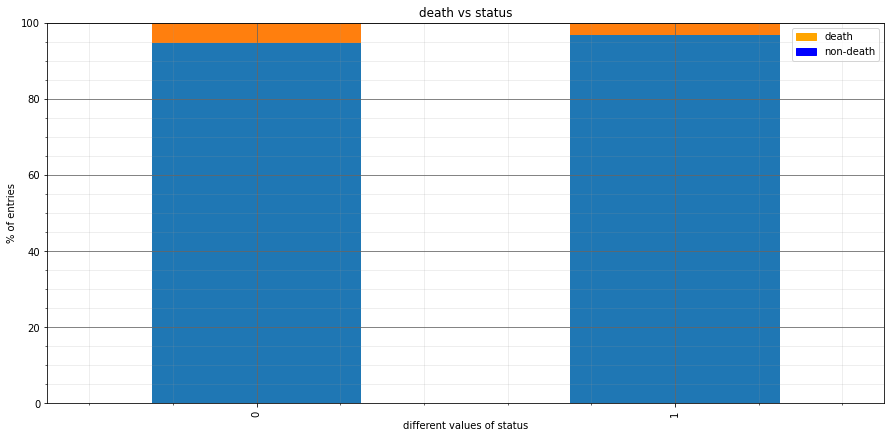

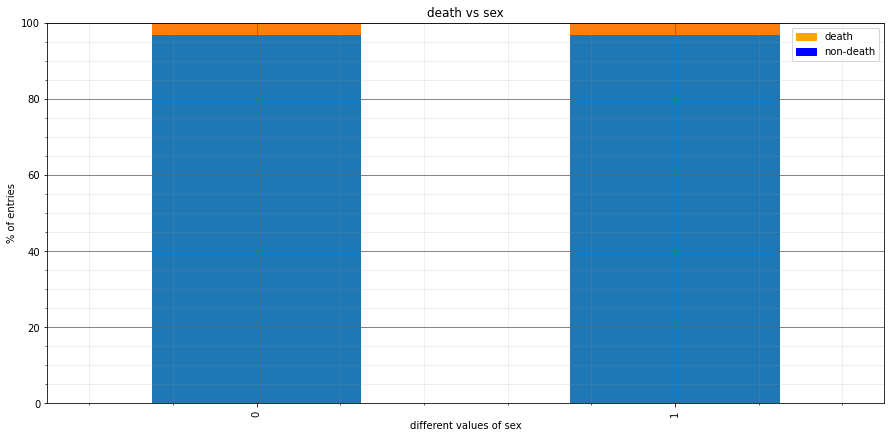

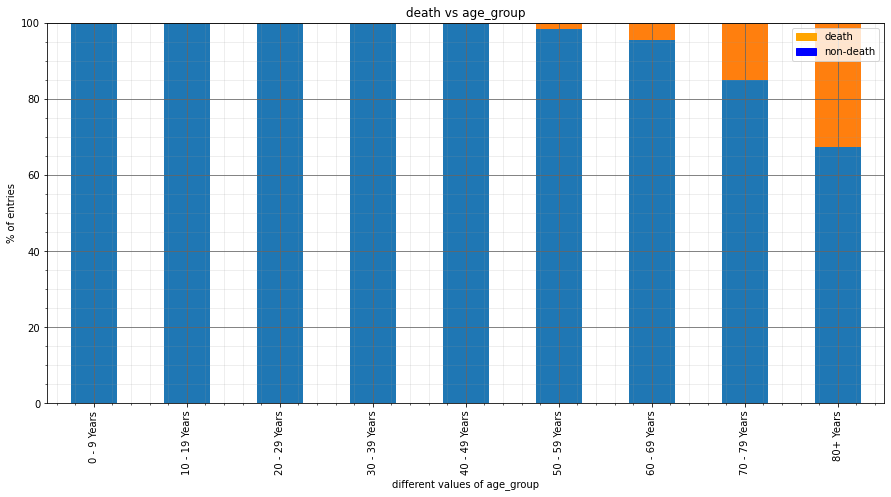

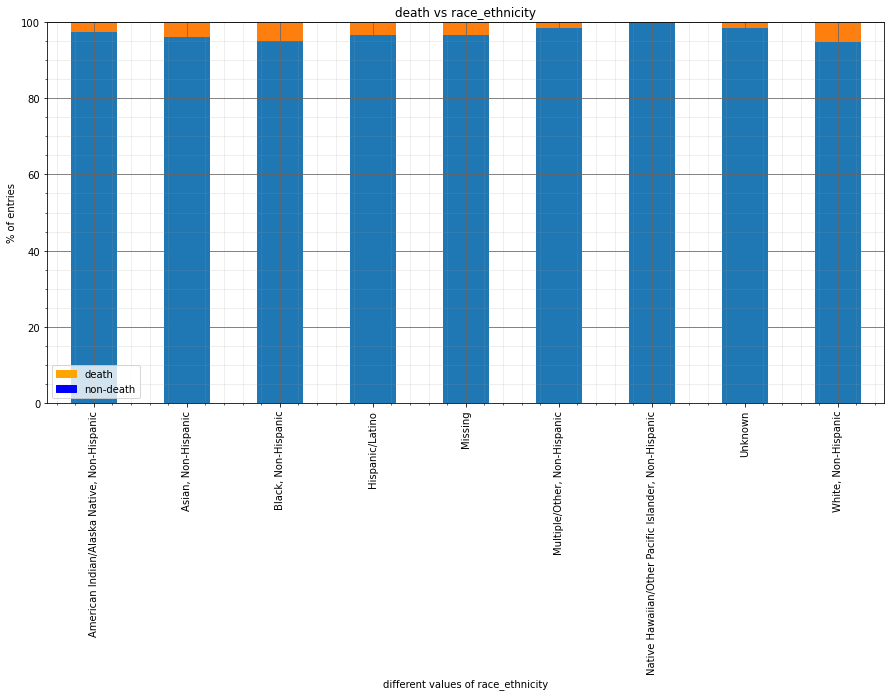

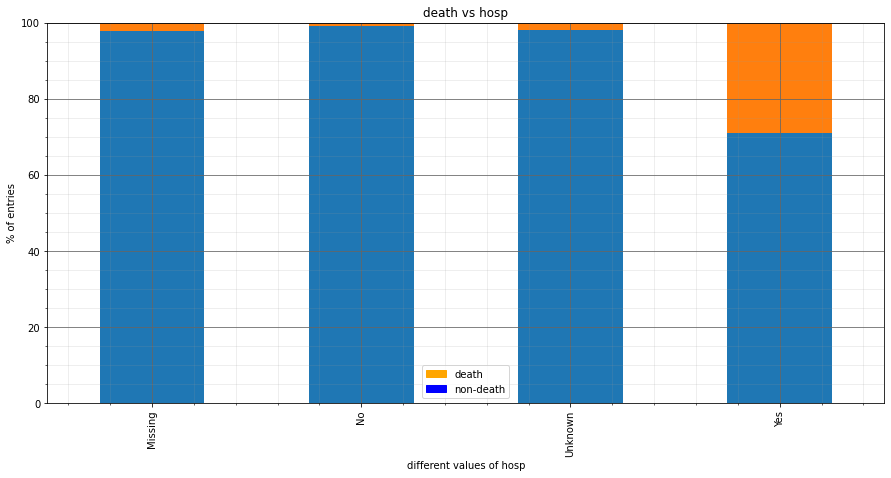

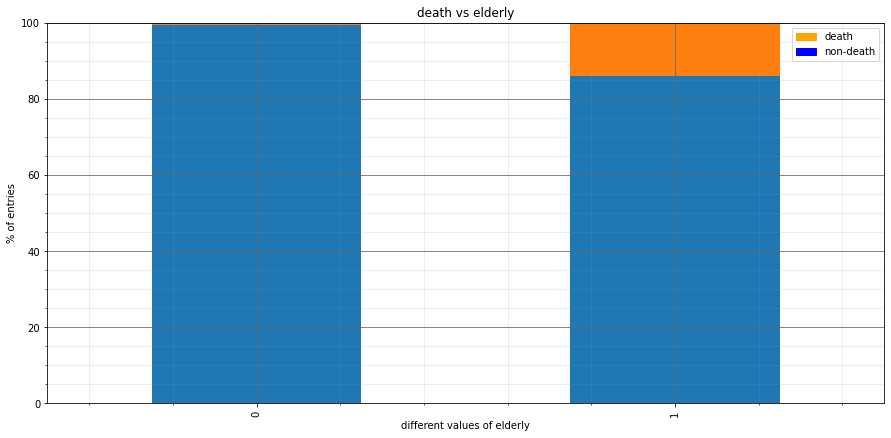

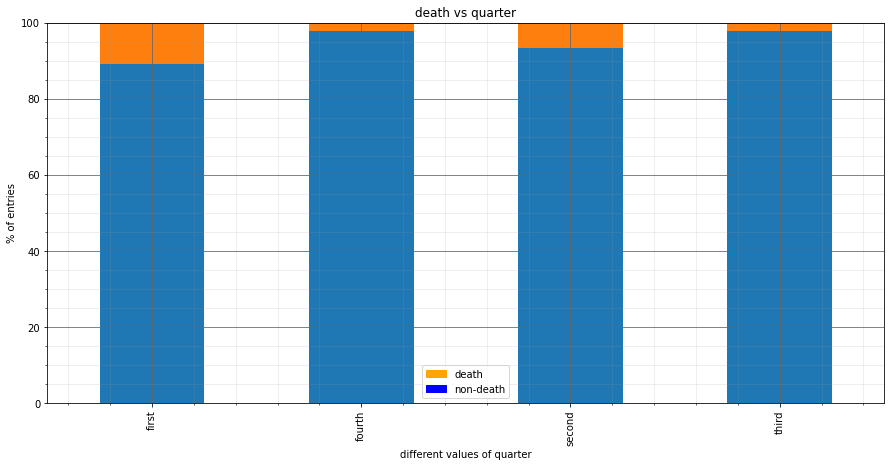

In [33]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")
#X_train[categorical_columns].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical:
    # Using code from the module lab
    
    allCategories = pd.unique(df_temp[categorical_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n" + categorical_feature)
    print("Index \t Count")

    # for each delinquency category
    for i in allCategories:

        count = df_temp[df_temp[categorical_feature] == i].count()['death']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'death']].groupby([categorical_feature,'death']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"death vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='death')
    blue_patch = mpatches.Patch(color='blue', label='non-death')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    # add labels
    my_plot.set_xlabel(f"different values of {categorical_feature}")
    my_plot.set_ylabel("% of entries")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### Reminder of scale meanings

| status      | meaning                   |
|-------------|---------------------------|
| 0           | Probable case             |
| 1           | Laboratory-confirmed case |

<br>

| sex         | meaning   |
|-------------|-----------|
| 0           | Male      |
| 1           | Female    |

<br>

| elderly     | meaning  |
|-------------|----------|
| 0           | no       |
| 1           | yes      |


### Interpretation of the results

##### death vs status
- Observing the plot, we can see that the chances of a death are slightly higher with a status of 'Probable case' than with 'Laboratory-confirmed case'. This is not expected.
- However, this may be due to the fact that there are far more 'Laboratory-confirmed case' entries than 'Probable case' ones: there are 6497 'Laboratory-confirmed case' entries and 290 'Probable case' ones. This can be seen in the cell underneath this.
    - Perhaps if we had more 'Probable case' entries, the results may be different.
- Because of this, it is difficult to say that a 'Probable case' is more likely to lead to death than a 'Laboratory-confirmed case', without having more entries of 'Probable case'

In [34]:
# 'Laboratory-confirmed case'
df_temp[df_temp['status']==1].shape[0]

6497

In [35]:
# 'Probable case'
df_temp[df_temp['status']==0].shape[0]

290

##### death vs sex
- Observing the plot, we can see that the chances of death are not strongly affected by the sex of the patient. There is a similar percentage of deaths for both: ~3%. As we can see in the cell below:

In [36]:
# percentage of male deaths
(df_temp.loc[(df_temp['sex']==0)&(df_temp['death']==1)].shape[0]/df_temp.loc[(df_temp['sex']==0)].shape[0])*100

3.2158317872603583

In [37]:
# percentage of female deaths
(df_temp.loc[(df_temp['sex']==1)&(df_temp['death']==1)].shape[0]/df_temp.loc[(df_temp['sex']==1)].shape[0])*100

3.23670137911624

##### death vs age_group

- Observing the plot above, we can see the correlation between increasing age and the likelihood of death. Particularly in the '70–79 years' and '80+ years' categories, the percentages of death are the highest.
- This is to be expected and will be backed up by the 'elderly' feature later.  

##### death vs race_ethnicity

- Observing the plot above, we can see now clear correlation between race/ethnicity and the likelihood of death.
- However, some of the the values in this category do not have much data compared to others. So, results may change if more data for more different races.
- There is a high amount of missing data for this feature: over 40%.
- We can see evidence of the overall lack of data for many races/ethnicities below.

In [38]:
print("Percentages for each race:\n")
for race in df_temp['race_ethnicity'].unique():
    print(race + ": " + str(df_temp.loc[(df_temp['race_ethnicity']==race)].shape[0]/df_temp.shape[0]*100)+"%")

Percentages for each race:

Unknown: 41.13746869014292%
Black, Non-Hispanic: 7.101812288198025%
White, Non-Hispanic: 32.78326211875645%
Multiple/Other, Non-Hispanic: 5.30425814056284%
Hispanic/Latino: 9.297185796375423%
Missing: 0.9135111242080447%
Asian, Non-Hispanic: 2.6668631206718727%
American Indian/Alaska Native, Non-Hispanic: 0.5598939148371888%
Native Hawaiian/Other Pacific Islander, Non-Hispanic: 0.23574480624723734%


##### death vs hosp

- Observing the plot above, we can see a clear correlation between being hospitalised and the likelihood of death.
- Almost 30% of hospital cases result in death, compared with ~1% of cases that don't.
- The entries with missing data for this feature show a slightly larger percentage of deaths, but nothing close to that of hospitalised cases.

##### death vs elderly

- Observing the plot above, we can see a clear correlation between elderly entries and the likelihood of death. 
- Almost 15% of elderly entries result in a death, compared to less than 1% of non-elderly entries.

##### death vs quarter
- Observing the final plot above, we see a correlation between the percentage and the part of the year.
- The percentage of deaths for the first 2 quarters is higher than that of the last 2.

### Actions to take:
- I will drop the feature **'status'**. There is not a strong correlation between it and the likelihood of death, and there is not a large enough sample size of 'Probable case' entries for this feature.
- I will drop the feature **'sex'**. Both values for this feature have ~3% likelihood of death, so there is no indication that this feature will help in predicting death.
- I will drop the feature **'race_ethnicity'**. There is not a large enough sample size for most values of this feature: ~40% of its values are missing, and ~30% of the entries are the value 'White, Non-Hispanic'.
    - There also is not a big variation in percentages of deaths for each race/ethnicity.
- I will drop the feature **'elderly'**. There is a clear correlation between it and the likelihood of death. However, it is less specific than 'age_group' which also has a strong correlation between its value and the likelihood of death.

### 1.2.3 Summary & Drop Features

1. From Continuous vs Target plots (1.2.1) we identified the following to be dropped  
    - report_date
    - time_dif
2. From Categorical vs Target (1.2.3) we identified the following to be dropped
    - status
    - sex
    - race_ethnicity

We will now drop these features
- Before dropping we will duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)

In [39]:
continuous_drop = list(df[['report_date', 'time_dif', 'earliest_date']].columns)
categorical_drop = list(df[['status', 'sex', 'race_ethnicity', 'missing_report', 'elderly']].columns)

dropped = list(set(continuous_drop + categorical_drop))

# make copy of dataframe
df_rev1 = df.copy()

df_rev1.drop(dropped, 1, inplace=True)

print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['age_group', 'hosp', 'death', 'quarter'], dtype='object')

New shape: (9697, 4)


## 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included

#### Set up dummy features. 
This will split up each categorical feature into a number of dummy features. The data type changes to "uint8"

- The feature "age_group" is categorical, with values '0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years', '70 - 79 Years' and '80+ Years'. These will be transformed into numerical features using binary encoding. It will be easier to read in the dataframe than integer encoding.
- The "quarter" feature is categorical, with values "first", "second", "third" and "fourth". These will be tansformed into numerical features using binary encoding.

In [40]:
# set up dummies features
df_rev1 = pd.get_dummies(df_rev1)
df_rev1.dtypes

death                      int64
age_group_0 - 9 Years      uint8
age_group_10 - 19 Years    uint8
age_group_20 - 29 Years    uint8
age_group_30 - 39 Years    uint8
age_group_40 - 49 Years    uint8
age_group_50 - 59 Years    uint8
age_group_60 - 69 Years    uint8
age_group_70 - 79 Years    uint8
age_group_80+ Years        uint8
hosp_Missing               uint8
hosp_No                    uint8
hosp_Unknown               uint8
hosp_Yes                   uint8
quarter_first              uint8
quarter_fourth             uint8
quarter_second             uint8
quarter_third              uint8
dtype: object

#### Remove redundant features
We do not need to keep 'age_group_0 – 9 Years', 'hosp_missing' or 'quarter_first'. These will now be dropped.

In [41]:
df_rev1 = df_rev1.drop(['age_group_0 - 9 Years','hosp_Missing', 'quarter_first'],1)

#### Categorical columns are:

In [42]:
categorical = df_rev1.select_dtypes(include=['int64', 'uint8']).columns.tolist()
categorical.pop(0)
categorical

['age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'hosp_No',
 'hosp_Unknown',
 'hosp_Yes',
 'quarter_fourth',
 'quarter_second',
 'quarter_third']

#### Total features are:

In [43]:
features = categorical
features

['age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'hosp_No',
 'hosp_Unknown',
 'hosp_Yes',
 'quarter_fourth',
 'quarter_second',
 'quarter_third']

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [44]:
# y is the target
y = df_rev1["death"]
# X is everything else
X = df_rev1.drop(["death"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9697
training range (70%):	 rows 0 to 6787
test range (30%): 	 rows 6787 to 9697


In [45]:
print("\nDescriptive features in X:\n" + str(X_train.head(5)))
print("\nTarget feature in y:\n" + str(y_train.head(5)))


Descriptive features in X:
      age_group_10 - 19 Years  age_group_20 - 29 Years  \
5422                        0                        0   
2529                        0                        0   
7101                        0                        0   
6241                        0                        1   
2815                        0                        0   

      age_group_30 - 39 Years  age_group_40 - 49 Years  \
5422                        1                        0   
2529                        0                        0   
7101                        0                        0   
6241                        0                        0   
2815                        0                        0   

      age_group_50 - 59 Years  age_group_60 - 69 Years  \
5422                        0                        0   
2529                        0                        1   
7101                        0                        0   
6241                        0             

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [46]:
X_train.head()

,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,hosp_No,hosp_Unknown,hosp_Yes,quarter_fourth,quarter_second,quarter_third
5422,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2529,0,0,0,0,0,1,0,0,0,0,0,0,0,1
7101,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6241,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2815,0,0,0,0,0,1,0,0,0,1,0,1,0,0


In [47]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,hosp_No,hosp_Unknown,hosp_Yes,quarter_fourth,quarter_second,quarter_third
0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,1,0,0,0,1,0,1,0,0


The datasets are now ready for modeling

## (2) Linear Regression Model
### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above

In [48]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

### 2.2.1 Print out the coefficients learned by the model


Features are: 
 Index(['age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_No',
       'hosp_Unknown', 'hosp_Yes', 'quarter_fourth', 'quarter_second',
       'quarter_third'],
      dtype='object')

Coeficients are: 
 [-0.00180299 -0.00501887 -0.00377889 -0.00880146 -0.00077769  0.01647537
  0.10322368  0.25809879 -0.00923587  0.00197956  0.20042244 -0.03228834
 -0.01373709 -0.03493683]

Intercept is: 
 0.035222222555672596

Features and coeficients: 
 [('age_group_10 - 19 Years', -0.001802993310214471), ('age_group_20 - 29 Years', -0.005018870483134937), ('age_group_30 - 39 Years', -0.003778887770674145), ('age_group_40 - 49 Years', -0.008801457360432195), ('age_group_50 - 59 Years', -0.0007776875131732007), ('age_group_60 - 69 Years', 0.016475374796475272), ('age_group_70 - 79 Years', 0.103223675761

<BarContainer object of 14 artists>

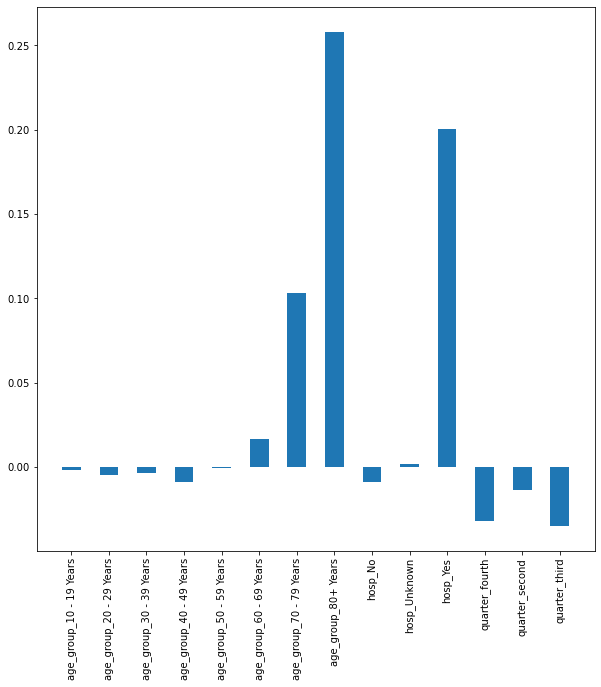

In [49]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))

# plot the co-efficients in a bar chart
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.bar(X_train.columns, multiple_linreg.coef_, 0.5)

### 2.2.2 Interpreting the linear regression model

The following explanation was adapted from sample exercise COMP47350-sample_solution_Task2-PredictiveModeling-Evaluation-CreditRiskPrediction:
https://brightspace.ucd.ie/d2l/le/content/106013/viewContent/1420923/View

- Linear regression is a modeling tool that is used to make predictions based on linear relationship between the target (dependent variable) and any number of predictors (independent variables)
    - It finds the line of best fit the describes the relationship between the target and predictors 
    - This line is calculated by minimising the overall error
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    - The output of this formula will be a continuous value that can be less than 0 and higher than 1
- We can see the calculated intercept is 190.47
    - This is the starting point. i.e. if all other coefficients are zero then the model result will be 190.47
    - If the model were plotted on a graph, this is where the model line would intercept the y axis
- We can see all the coefficients for each feature
    - These are zipped together in a single list for ease of inspection.
    - The sum of all the feature*coefficients + intercept will result in the model prediction  
- Each feature is a binary 0 or 1. As we can see, the co-efficients for "age_group_80+ Years", "age_group_70 – 79 Years" and "hosp" have the biggest effect on predicting the target outcome. 
    - This makes sense when looking back at the plots in section 1.2.2, where the biggest correlations with death were a "Yes" value for "hosp", "70–79 Years" for "age_group" and "80+ Years" for "age_group".
- A problem that I can see for training the prediction model on this data is the massive discrepancy in numbers of deaths versus numbers of non-deaths. The model has far fewer cases in which a death occurs, so it does not get as much training for perdicting a death. This of course is in-line with the statistics on COVID-19 – there are far more non-deaths than deaths – so, perhaps more data is needed to train the model more accurately. 
    
As we have learned, it is important to note that the output from a linear regression model is not suited to the classification problem that we are trying to solve.
- The output is not a probability and an additional thresholding step is necessary to convert the output into a binary classification
- We will threshold the output so that any values >=0.5 will be cast to 1, any values <0.5 will be cast to 0

<img src="linear_regression_outliers.png"> <br>
source: https://medium.com/@rgotesman1/learning-machine-learning-part-3-logistic-regression-94db47a94ea3

### 2.3.1 Print the predicted target feature value for the first 10 training examples.
- Here we will print the predicted target feature value for the first 10 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

In [50]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death  Predicted
0      0        0.0
1      0        0.0
2      0        0.0
3      0        0.0
4      0        0.0
5      0        0.0
6      0        0.0
7      0        0.0
8      0        0.0
9      0        0.0


### 2.3.2 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [51]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9677324296449094
Confusion matrix: 
 [[6568    0]
 [ 219    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6568
           1       0.00      0.00      0.00       219

    accuracy                           0.97      6787
   macro avg       0.48      0.50      0.49      6787
weighted avg       0.94      0.97      0.95      6787



##### Interpretation of results
- Accuracy
    - This is simply stating how often the model is correct. We have an accuracy of ~97%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
- Precision - How good the model is at predicting the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - Precision Positive is 0.00
    - Precision Negative is 0.97
- Recall
    - What % of the positive values did we predict
    - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 0.00
    - Recall Negative is 1.00
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.00
    - F1 Score Negative is 0.98

Summary
- The model does not predict any positives – it only predicts negatives. 
- This makes sense as the model has far more negative data to learn from - it is the majority class: ~3% of the dataframe's entries are positives, while the rest are negatives. 
- This is not good. Predicting non-death 100% of the time is not prediction.
- It would be better for the model to predict more deaths than actually occur – by as small ammount as possible – as it means more patients that need special attention would get it.
- The down side of this would be that people who need special attention may not get it if hospital resources are stretched from the other patients who have been evaluated as needing special attention. However, this is still better than predicting that no patients need special attention.

#### 2.3.3 Retrying the model with a lower threshold
- **For my own investigation, I will try the model with a lower threshold to see how accurate it is.**
- We will threshold the predicted target feature value given by the linear regression model at 0.25, to get the predicted class for each example. 
    - If value is >= 0.25 it is cast to 1, if < 0.25 it is cast to 0

In [52]:
# calculate the prediction and threshold the value. If >= 0.25 its true
multiple_linreg_predictions_train_2 = (multiple_linreg.predict(X_train) >= 0.25) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg_2 = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train_2, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg_2.head(10))


Predictions with multiple linear regression: 

   death  Predicted
0      0        0.0
1      0        0.0
2      0        1.0
3      0        0.0
4      0        0.0
5      0        0.0
6      0        0.0
7      0        0.0
8      0        0.0
9      0        0.0


#### 2.3.4 Evaluation metrics based on training data (2)
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [53]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train_2))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train_2))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train_2))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9538824222778842
Confusion matrix: 
 [[6326  242]
 [  71  148]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.96      0.98      6568
           1       0.38      0.68      0.49       219

    accuracy                           0.95      6787
   macro avg       0.68      0.82      0.73      6787
weighted avg       0.97      0.95      0.96      6787



##### Interpretation of results (2)
- Accuracy
    - We have an accuracy of ~95%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
    
- Precision - How good the model is at predicting the positive class
    - Precision Positive is now 0.38
    - Precision Negative is now 0.99
- Recall
    - Recall Positive is now 0.68
    - Recall Negative is now 0.97
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is now 0.49
    - F1 Score Negative is now 0.98

Summary
- This is an improvement over the previous threshold.
- The model's precision positive is still only 0.38.
    - However, it now predicts more true positives than it does false negatives.
- It makes sense that the model is not very accurate at predicting positives as it has far more negative data to learn from, as I said above. 
- This is still not ideal – the low precision – but it is better than the threshold of 0.5.
- It is better that the model predicts more deaths correctly than non-deaths incorrectly.
- The down side of this is that there are still false negatives predicted, and the precision of the positive prediction is low.

- **Because of the instructions for this exercise – which specified setting the threshold at 0.5 – I will not use the model with the lower threshold for further testing**

### 2.4.1 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

In [54]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death  Predicted
0      0        0.0
1      0        0.0
2      0        0.0
3      0        0.0
4      1        0.0
5      1        0.0
6      0        0.0
7      0        0.0
8      0        0.0
9      0        0.0


##### Evaluation metrics based on test data

In [55]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.965979381443299
Confusion matrix: 
 [[2811    0]
 [  99    0]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2811
           1       0.00      0.00      0.00        99

    accuracy                           0.97      2910
   macro avg       0.48      0.50      0.49      2910
weighted avg       0.93      0.97      0.95      2910


==================== Train Data ======================
Accuracy:  0.9677324296449094
Confusion matrix: 
 [[6568    0]
 [ 219    0]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6568
           1       0.00      0.00      0.00       219

    accuracy                           0.97      6787
   macro avg       0.48      0.50      0.49      6787
weighted avg       0.94      0.97      0.95      6787



**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test and train data is in-line at ~97% (the train data is slightly higher: 96.8% versus 96.6%)
- Precision
    - The precision score for predicting the positive case is 0% in both test and train data.
    - The precision score for predicting the negative case has also stayed the same for both test and train data
- Recall
    - The recall score for predicting the positive case is 0% in both test and train data.
    - The recall score for predicting the negative case is 100% in both test and train data.
- F1
    - The f1 score for predicting the positive case is 0% in both test and train data.
    - The f1 score for predicting the negative case has stayed at 98% in both test and train data.

**Summary**
- The values are much the same in both the test and train data
- Thus, all of the issues with the prediction model for the train data remain for the test data
- We will now use cross validation for more comparisons to be made

#### 2.4.2 Cross validation
- We will now perform cross validation on the linear regression model. 
- Here we perform the same evaluation as above but multiple times
- Each time the data is shuffled so we get a slightly different view of the data for training and testing
- This works well for evaluating on a limited set of data
- We will store the results in a dictionary for later use

First we need to create a function to perform this cross validation. Sklearn does not provide one for linear regression. However it does for logistic and random forests models
- Cross validation Function can be seen below, which is taken from sample exercise COMP47350-sample_solution_Task2-PredictiveModeling-Evaluation-CreditRiskPrediction:
https://brightspace.ucd.ie/d2l/le/content/106013/viewContent/1420923/View

In [56]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.
- This function is taken from sample exercise COMP47350-sample_solution_Task2-PredictiveModeling-Evaluation-CreditRiskPrediction:
https://brightspace.ucd.ie/d2l/le/content/106013/viewContent/1420923/View

In [57]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarised below

In [58]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.969107
precision,0.390035
recall,0.050001
f1,0.080018


The accuracy results are mostly the same. The precision for predicting positives is higher than before. The recall and f1 are also slightly higher. We have taken the mean of 10 sets of results. 

## (3) Logistic Regression

### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above

In [59]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

### 3.2.1 Print out the coefficients learned by the model


Features are: 
 Index(['age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_No',
       'hosp_Unknown', 'hosp_Yes', 'quarter_fourth', 'quarter_second',
       'quarter_third'],
      dtype='object')

Coeficients are: 
 [-1.40792095 -1.83719875 -0.83371267 -0.89160839  0.1919248   1.05054955
  2.21466131  3.13508638 -0.8272355   0.01604949  1.84408926 -0.80815988
 -0.11060672 -0.81625045]

Intercept is: 
 [-3.84108851]

Features and coeficients: 
 [('age_group_10 - 19 Years', -1.407920951614408), ('age_group_20 - 29 Years', -1.8371987542091683), ('age_group_30 - 39 Years', -0.8337126705078185), ('age_group_40 - 49 Years', -0.8916083864163719), ('age_group_50 - 59 Years', 0.19192480116255647), ('age_group_60 - 69 Years', 1.0505495519196373), ('age_group_70 - 79 Years', 2.2146613148262397), ('age_group_80

<BarContainer object of 14 artists>

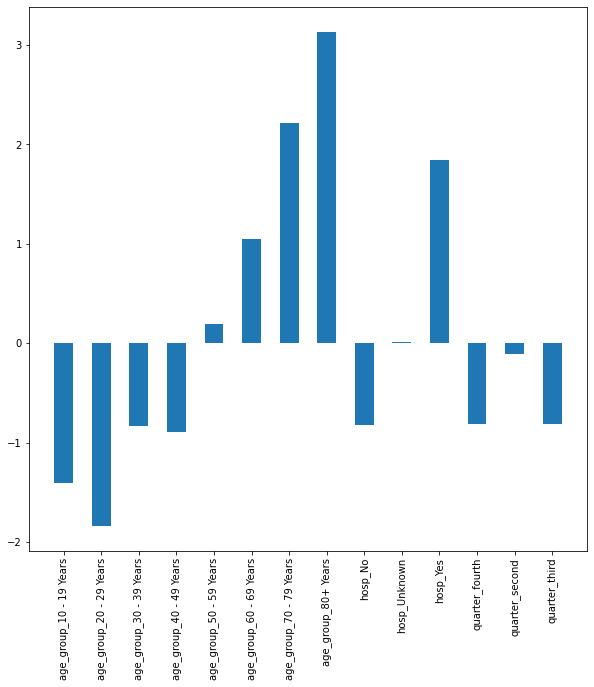

In [60]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))

# plot the co-efficients in a bar chart
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.bar(X_train.columns, multiple_logisticreg.coef_[0], 0.5)

#### 3.2.2 Interpreting the results 

The following explanation was adapted from sample exercise COMP47350-sample_solution_Task2-PredictiveModeling-Evaluation-CreditRiskPrediction:
https://brightspace.ucd.ie/d2l/le/content/106013/viewContent/1420923/View

The logistic regression function is a little different than the linear regression function. 
- The output of the logistic function is a probability, a value between 0 and 1
- The output of the linear function is a continuous value that is not a probability
- Differences aside there is a direct relationship between the two
    - The first part of logistic regression function is similar to linear regression i.e. We find the line of best fit
    - We then pass this equation through what is called a sigmoid function
    - This sigmoid function will output a value bound between 0 and 1. It is a probability
    - The model then applies a threshold to this probability so that if is is >= 0.5 its cast to 1 and if it is <0.5 it is cast to 0
    - All of these steps are carried out within the logistic regression function, however the threshold value can be adjusted up or down depending on the problem you are trying to solve.

The model estimated in logistic regression is given by the logistic function: <br>
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

- From the values above can see the calculated intercept is -3.84108851
    - This is the starting point. i.e. if all other coefficients were zero then the value for 'x' would be -3.84108851. 
    - This is the input to the logistic function and the logistic function will then calculate the probability and threshold based on this.
- We can see all the coefficients for each features
    - These are zipped together in a single list for ease of inspection.
    - The effect of these on the value 'x' is the same as for linear regression
    - Only when the value 'x' is fed into the logistic function do we see the real difference between the to methods.
    
<img src="logistic_regression_outliers.png"> <br>
Source: https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102

### 3.3.1 Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 10 training examples based on training data

In [61]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   death  Predicted
0      0          0
1      0          0
2      0          0
3      0          0
4      0          0
5      0          0
6      0          0
7      0          0
8      0          0
9      0          0


#### 3.3.2 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [62]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9700898777073818
Confusion matrix: 
 [[6508   60]
 [ 143   76]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      6568
           1       0.56      0.35      0.43       219

    accuracy                           0.97      6787
   macro avg       0.77      0.67      0.71      6787
weighted avg       0.96      0.97      0.97      6787



#### Interpretation of results
- Accuracy
    - We have an accuracy of ~97%
- Precision - How good model is at predicting the positive class
    - Precision Positive is 0.56
    - Precision Negative is 0.98
- Recall - What % of the positive values did we predict
    - Recall Positive is 0.35
    - Recall Negative is 0.99
- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.43
    - F1 Score Negative is 0.98

Summary
- These values are better than the linear regression model
- The overall accuarcy is about the same, but this model predicts positives with better precision while maintaining its accuracy in predicting negative cases.
- It would still be better for the model to predict more deaths than actually occur – by as small ammount as possible – as it means more patients that need special attention would get it.
- The downside here would still be that people who need special attention may not get it if hospital resources are stretched from the other patients who have been evaluated as needing special attention. However, it is better to be conservative in this approach, and over predict the number of patients that will need special care.

### 3.4.1 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [63]:
X_test.columns

Index(['age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_No',
       'hosp_Unknown', 'hosp_Yes', 'quarter_fourth', 'quarter_second',
       'quarter_third'],
      dtype='object')

In [64]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death  Predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       1          0
5       1          0
6       0          0
7       0          0
8       0          0
9       0          0
10      0          0
11      0          0
12      0          0
13      0          0
14      0          0
15      0          0
16      0          0
17      0          0
18      0          0
19      0          0


Evaluation based on test data

In [65]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9683848797250859
Confusion matrix: 
 [[2788   23]
 [  69   30]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2811
           1       0.57      0.30      0.39        99

    accuracy                           0.97      2910
   macro avg       0.77      0.65      0.69      2910
weighted avg       0.96      0.97      0.96      2910

==================== Train Data =======================
Accuracy:  0.9700898777073818
Confusion matrix: 
 [[6508   60]
 [ 143   76]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      6568
           1       0.56      0.35      0.43       219

    accuracy                           0.97      6787
   macro avg       0.77      0.67      0.71      6787
weighted avg       0.96      0.97      0.97      6787



#### Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data is slightly lower: 96.8% vs 97%. 
- Precision
    - The precision score for predicting the positive case has increased from 56% to 57%.
    - The precision score for predicting the negative case has stayed at 98%.
- Recall
    - The recall score for predicting the positive case has decreased from 35% to 30%.
    - The recall score for predicting the negative case has stayed at 99%.
- F1
    - The f1 score for predicting the positive case has decreased from 43% to 39%.
    - The f1 score for predicting the negative case has stayed at 98%.

Summary
- These values seem reasonable
- The overall accuracy level has remained the same, and the precision has increased slightly; while the recall and f1 values have decreased slightly.
- This is a good sign that the model is generalizing
- More comparisons need to be made and this is where cross validation steps in

#### 3.4.2 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [66]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [67]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.969475
precision,0.565538
recall,0.323589
f1,0.407749


These results are in line with the previous results. We have taken the mean of 10 sets of results. 

## (4) Random Forest Model

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

In [68]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### 4.2 Understanding the Random Forest model

The following explanation was adapted from sample exercise COMP47350-sample_solution_Task2-PredictiveModeling-Evaluation-CreditRiskPrediction:
https://brightspace.ucd.ie/d2l/le/content/106013/viewContent/1420923/View

We will now try to understand how this random forest model works
- We will first start by trying to understand a decision tree 
- A random forest is made up of an ensemble/collection of decision trees
- Decision tree
    - A decision tree is a set of if-then-else rules based on splitting the data based on specific features
    - The decision on which feature to split on is based on the information gain (Gini index). 
    - The tree will always split on the feature that gives the highest information gain
    - The feature with the highest information gain will sit at the root of each decision tree
    - Each decision tree will be a single prediction
- Random Forest 
    - The random forest is made up of a number of decision trees
    - The output of the random forest is based on the majority output of all decision trees combined
    - This gives reliable results but can be hard to interpret
    - The random forest will keep track of the importance of features in terms of information gain, which we will see
    
We will now look at an example of a single decision tree to get a better understanding

####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer

In [69]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


###  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [70]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

We can see below the decision tree with max_depth=4
- We can see the root is hosp_yes at value 0.5, which is the most important feature.
- For each split the the model selects the next best feature, which after 'hosp_Yes' is 'age_group_80+ Years'
- This continues until it reaches a leaf node where the data cannot be split anymore
- The output of this is the prediction
- There is one path below is resolved in 3 branches
    - hosp_Yes >= 0.5 -> age_group_80+ Years >= 0.5 -> quarter_second >= 0.5 -> Resolved to TRUE
    - Note: only 1 entry meets this requirement.
    - All other entries need additional branches to be resolved

<img src="DecisionTree4.png">

Viewing a decision tree with maxdepth=10 shows how complicated this model becomes 
- This is only one example of a decision tree. 
- A Random forests has 100 decision trees by default
- Each decision tree is given a slightly different view of the data

<img src="DecisionTree10.png">

### 4.2.3 Interpretation of the random forest model

The following explanation was adapted from sample exercise COMP47350-sample_solution_Task2-PredictiveModeling-Evaluation-CreditRiskPrediction:
https://brightspace.ucd.ie/d2l/le/content/106013/viewContent/1420923/View

As mentioned above the random forest will keep track of the importance of features
- We can see from the dataframe below the results of this feature importance ranking
- The more important features are the features that the random forest has identified as having higher information gain
- This list is the combined result of the 100 decision trees that make up the random forest model
- This feature ranking will help us in our optimisation process going forward
    - What are the best features to keep?
    - What features can be safely dropped without loosing information?

In [71]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
10,hosp_Yes,0.309696
7,age_group_80+ Years,0.303417
6,age_group_70 - 79 Years,0.083702
11,quarter_fourth,0.044890
12,quarter_second,0.043668
13,quarter_third,0.041838
8,hosp_No,0.041330
9,hosp_Unknown,0.025220
4,age_group_50 - 59 Years,0.021421
3,age_group_40 - 49 Years,0.020773


We can see from the list above that some of the features provide little to no information gain: especially 'age_group_10 - 19 Years', which has an importance of less than 1%. While 'hosp_Yes' and 'age_group_80+ Years' are far higher than the other features with ~30% importance each.

### 4.3.1 Printing 10 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 10 training examples. 

In [72]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


### 4.3.2 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [73]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9721526447620451
Confusion matrix: 
 [[6549   19]
 [ 170   49]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6568
           1       0.72      0.22      0.34       219

    accuracy                           0.97      6787
   macro avg       0.85      0.61      0.66      6787
weighted avg       0.97      0.97      0.96      6787



#### Interpretation of results
- Accuracy
    - This is simply stating how often the model is correct. We have an accuracy of ~97%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
- Precision - How good the model is at predicting the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - Precision Positive is 0.72
    - Precision Negative is 0.97
- Recall
    - What % of the positive values did we predict
    - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 0.22
    - Recall Negative is 1.00
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.34
    - F1 Score Negative is 0.99

Summary
- The model has the highest number of precision for positives and negatives of all the models.
- However, its values for Recall and F1 score were not as high as logisitical regression.

### 4.4.1 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing actual death vs predicted based on test data

In [74]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(10)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,1,0
6,0,0
7,0,0
8,0,0
9,0,0


Evaluation metrics based on test data

In [75]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9673539518900344
Confusion matrix: 
 [[2801   10]
 [  85   14]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2811
           1       0.58      0.14      0.23        99

    accuracy                           0.97      2910
   macro avg       0.78      0.57      0.61      2910
weighted avg       0.96      0.97      0.96      2910

==================== Train Data =======================
Accuracy:  0.9721526447620451
Confusion matrix: 
 [[6549   19]
 [ 170   49]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6568
           1       0.72      0.22      0.34       219

    accuracy                           0.97      6787
   macro avg       0.85      0.61      0.66      6787
weighted avg       0.97      0.97      0.96      6787



### 4.4.2 Interpretation of test results and comparison with training results 
- The accuracy for the test is much lower for all positive predictions as we are not testing the model with data it has not see before.
- It has the same accuracy for negative valus and weighted values.
- Its precision for positive values is still the highest of the 3 models tested

### 4.4.3 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [76]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [77]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.968959
precision,0.600783
recall,0.194556
f1,0.284643


The results above are inline with expectation
- The accuracy is the same
- The precision is higher than the other models
- The recall and f1 scores are higher than linear regression but lower than logistical regression

### 4.4.4 Out of bag accuracy
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.
- It is used as an additional measure and should be line with the cross validation results
- This is generally expected to be the lowest

In [78]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.971268601738618

This value is in line with the Cross validation results above

## 5 Improving Predictive Models

### 5.1.1 Which model of the ones trained above performs better at predicting the target feature? 
- All models perform almost identically on the test dataset in terms of accuracy
- However, the best in terms of precision, recall and f1 is the **logistic regression model**
- Summary of the results so far can be seen below (based on predicting positive outcome (death=1))
- Note these results are for a subset of the original features i.e. In part 1 we dropped many of the low correlation features
    - In part 5.2 we will review the impact to the decisions taken in part 1

##### Linear Regression
**accuracy:** 0.969107<br>
**precision:** 0.390035<br>
**recall:** 0.050001<br>
**f1:** 0.080018<br>

##### Logistic Regression
**accuracy:** 0.969475<br>
**precision:** 0.565538<br>
**recall:** 0.323589<br>
**f1:** 0.407749<br>

##### Random Forests
**accuracy:** 0.968959 <br>
**precision:** 0.600783<br>
**recall:** 0.194556<br>
**f1:** 0.284643<br>

### 5.1.2 Is the model more accurate than a simple model that always predicts the majority class
- We will compare our results above to a simple model which predicts for the majority class
- First we will get the breakdown of the test dataset and see which is the majority class

In [79]:
pos_count = y_test[y_test == 1].count()
neg_count = y_test[y_test == 0].count()
total = pos_count+ neg_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number death:\t {pos_count}\t{round(pos_count/len(y_test)*100,2)}%')
print(f'Total number non-death:\t {neg_count}\t{round(neg_count/len(y_test)*100,2)}%')

From original dataset: 		Count 2910
Total number death:	 99	3.4%
Total number non-death:	 2811	96.6%


- We can see the majority class is 0 or non-death 
- We will now generate scores for predicting the majority class

In [80]:
# generate array of 2910 zeros (length of test dataset)
majority = np.zeros(2910)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.965979381443299
Confusion matrix: 
 [[2811    0]
 [  99    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2811
           1       0.00      0.00      0.00        99

    accuracy                           0.97      2910
   macro avg       0.48      0.50      0.49      2910
weighted avg       0.93      0.97      0.95      2910



- For predicting good outcome the simple model fails completely as expected
- For predicting the bad outcome the simple model fares much better
- However, this is because 97% of the data is a negative vaue, so predicting a negative every time will lead to 97% accuracy, which all of the models have or have come close to achieving, while also predicting positives correctly.
    - The precision is the same as the accuracy in this case - i.e. how good is it at predicting 0
    - The recall is 100% as all of the actual 0 values were predicted 0
    - The f1 is between the precision and recall as it is a weighted average of the two

### 5.2.1 Summarise your understanding of the problem and of your predictive modeling results so far.

- Each trained model from this exercise has been ~97% accurate.
- However, this is possibly misleading, because ~97% of the data being trained and tested on is of a negative value.
    - Therefore any predictive models based on this data have a lot more negative outcomes to be trained on.
    - This makes training the model to accurately predict more positive outcomes difficult.
- It is possible that taking away the lower correlation features has given the random forest model fewer variations to choose from, so adding some of those features back and using them in the random forest model may lead to a more accurate model.

### 5.2.2 Compare Model performance using different feature subsets 
#### 5.2.2.1 All features
- We will now repeat the tests using all features 
- First we set up the dataframe using the original features
- Then we will remove redundant features before training and testing

In [81]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)

With the dataframe now setup we will generate new set of results based on all the features
- This operation is simplified as we have set up functions in part 2,3,4 to allow cross validated scores to be returned in dataframes 

In [82]:
df_all.head()

,earliest_date,report_date,status,sex,death,time_dif,elderly,missing_report,age_group_0 - 9 Years,age_group_10 - 19 Years,...,race_ethnicity_Unknown,"race_ethnicity_White, Non-Hispanic",hosp_Missing,hosp_No,hosp_Unknown,hosp_Yes,quarter_first,quarter_fourth,quarter_second,quarter_third
0,2020-12-16,2020-12-16,1,1,0,0 days,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1,2020-11-10,2020-11-13,1,0,0,3 days,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
2,2020-10-12,2020-10-16,1,1,0,4 days,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
3,2021-01-15,2021-01-15,1,0,0,0 days,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
4,2021-01-01,2021-01-01,1,1,0,0 days,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0


In [83]:
# change 'earliest_date' and 'report_date' to ordinal and 'time_dif' to int64

import datetime as dt
df_all['earliest_date']=df_all['earliest_date'].map(dt.datetime.toordinal)
df_all['report_date']=df_all['report_date'].map(dt.datetime.toordinal)

# convert time_dif to int
df_all['time_dif'] = df_all['time_dif'].dt.days.astype('int64')

# drop redundant columns: 'report_date', 'age_group_0 – 9 Years', 'race_ethnicity_American Indian/Alaska Native, Non-Hispanic'
# 'hosp_Missing', 'quarter_first', 'missing_report'

df_all = df_all.drop(['report_date', 'age_group_0 - 9 Years',\
                      'race_ethnicity_American Indian/Alaska Native, Non-Hispanic',\
                      'hosp_Missing', 'quarter_first', 'missing_report'],1)


df_all.dtypes

earliest_date                                                          int64
status                                                                 int64
sex                                                                    int64
death                                                                  int64
time_dif                                                               int64
elderly                                                                int64
age_group_10 - 19 Years                                                uint8
age_group_20 - 29 Years                                                uint8
age_group_30 - 39 Years                                                uint8
age_group_40 - 49 Years                                                uint8
age_group_50 - 59 Years                                                uint8
age_group_60 - 69 Years                                                uint8
age_group_70 - 79 Years                                                uint8

In [84]:
# set X,y
y = df_all["death"]
X = df_all.drop(["death"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  27


In [85]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.969519,0.967206,0.966587
precision,0.603954,0.000000,0.483361
recall,0.063560,0.000000,0.291935
f1,0.108219,0.000000,0.361859


- As we can see here, each model performs with ~97% accuracy as is the same with all previous tests.
- The Linear Regression model performs better in all scores, but is still not the most accurate of all models.
- The Logistic Regression model has 0% precision, recall and f1 scores when using all features
- The Random Forest model has a decreased precision to ~48% from ~60% but its recall and f1 scores have actually increased.

#### 5.2.2.2 All features, with dates removed
- We will now repeat the tests using all features except for the dates: 'earliest_date', 'report_date', and 'time_dif'
- First we set up the dataframe using the original features
- Then we will remove redundant features as before, and will also remove the features listed above

In [86]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)

In [87]:
# drop redundant columns: 'report_date', 'age_group_0 – 9 Years', 'race_ethnicity_American Indian/Alaska Native, Non-Hispanic'
# 'hosp_Missing', 'quarter_first', 'missing_report', 'earliest_date', 'time_dif'

df_all = df_all.drop(['earliest_date', 'report_date', 'age_group_0 - 9 Years',\
                      'race_ethnicity_American Indian/Alaska Native, Non-Hispanic',\
                      'hosp_Missing', 'quarter_first', 'missing_report', 'time_dif'],1)


df_all.dtypes

status                                                                 int64
sex                                                                    int64
death                                                                  int64
elderly                                                                int64
age_group_10 - 19 Years                                                uint8
age_group_20 - 29 Years                                                uint8
age_group_30 - 39 Years                                                uint8
age_group_40 - 49 Years                                                uint8
age_group_50 - 59 Years                                                uint8
age_group_60 - 69 Years                                                uint8
age_group_70 - 79 Years                                                uint8
age_group_80+ Years                                                    uint8
race_ethnicity_Asian, Non-Hispanic                                     uint8

In [88]:
# set X,y
y = df_all["death"]
X = df_all.drop(["death"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  25


In [89]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968763,0.969888,0.965969
precision,0.418373,0.584717,0.478343
recall,0.060813,0.304738,0.267137
f1,0.099815,0.396421,0.339516


- As we can see here, each model performs with ~97% accuracy again.
- The main thing to note for this test is the improvement of the logistic regression model without dates.
    - However, it is still less accurate than the first test.
- The Random Forest model has a decreased numbers for every score

#### 5.2.2.3 Remove the 'elderly' feature

In [90]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)

In [91]:
# drop redundant columns: 'report_date', 'age_group_0 – 9 Years', 'race_ethnicity_American Indian/Alaska Native, Non-Hispanic'
# 'hosp_Missing', 'quarter_first', 'missing_report', 'earliest_date', 'time_dif', 'elderly'

df_all = df_all.drop(['earliest_date', 'report_date', 'age_group_0 - 9 Years',\
                      'race_ethnicity_American Indian/Alaska Native, Non-Hispanic',\
                      'hosp_Missing', 'quarter_first', 'missing_report', 'time_dif',\
                     'elderly'],1)


df_all.dtypes

status                                                                 int64
sex                                                                    int64
death                                                                  int64
age_group_10 - 19 Years                                                uint8
age_group_20 - 29 Years                                                uint8
age_group_30 - 39 Years                                                uint8
age_group_40 - 49 Years                                                uint8
age_group_50 - 59 Years                                                uint8
age_group_60 - 69 Years                                                uint8
age_group_70 - 79 Years                                                uint8
age_group_80+ Years                                                    uint8
race_ethnicity_Asian, Non-Hispanic                                     uint8
race_ethnicity_Black, Non-Hispanic                                     uint8

In [92]:
# set X,y
y = df_all["death"]
X = df_all.drop(["death"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  24


In [93]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968729,0.970094,0.966278
precision,0.394375,0.594021,0.484755
recall,0.049326,0.304738,0.266935
f1,0.081633,0.398128,0.341531


- As we can see, the logistic regression model is slightly improved again, but is still not as good in the recall and f1 scores as its original test.

#### 5.2.2.4 Remove the 'quarter' features
- As these are date-related, and it has been established that dates are not the most relevant in the way of predicting a death, as described in section 1.2.1, we  will test the models with the 'quarter' features dropped.

In [94]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)

In [95]:
# drop redundant columns: 'report_date', 'age_group_0 – 9 Years', 'race_ethnicity_American Indian/Alaska Native, Non-Hispanic'
# 'hosp_Missing', 'quarter_first', 'missing_report', 'earliest_date', 'time_dif', 'elderly', 'quarter_fourth', 
# quarter_second', 'quarter_third '

df_all = df_all.drop(['earliest_date', 'report_date', 'age_group_0 - 9 Years',\
                      'race_ethnicity_American Indian/Alaska Native, Non-Hispanic',\
                      'hosp_Missing', 'quarter_first', 'missing_report', 'time_dif',\
                     'elderly', 'quarter_fourth', 'quarter_second', 'quarter_third'],1)


df_all.dtypes

status                                                                 int64
sex                                                                    int64
death                                                                  int64
age_group_10 - 19 Years                                                uint8
age_group_20 - 29 Years                                                uint8
age_group_30 - 39 Years                                                uint8
age_group_40 - 49 Years                                                uint8
age_group_50 - 59 Years                                                uint8
age_group_60 - 69 Years                                                uint8
age_group_70 - 79 Years                                                uint8
age_group_80+ Years                                                    uint8
race_ethnicity_Asian, Non-Hispanic                                     uint8
race_ethnicity_Black, Non-Hispanic                                     uint8

In [96]:
# set X,y
y = df_all["death"]
X = df_all.drop(["death"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  21


In [97]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968488,0.967826,0.966484
precision,0.193028,0.527218,0.477189
recall,0.039890,0.229637,0.247883
f1,0.061033,0.316401,0.324281


- This test sees a disimprovement on the logistic regression model: in recall especially, but also in f1 and precision.

#### 5.2.2.5 Remove the 'race_ethnicity' features but add back in the 'quarter' features
- As the removal of the 'quarter' features made the model less accurate, we will add them back in, and try the evaluation without the 'race_ethnicity' features, as they had a large number of missing values, and a low correlation

In [98]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)

In [99]:
# drop redundant columns: 'report_date', 'age_group_0 – 9 Years', 'race_ethnicity_American Indian/Alaska Native, Non-Hispanic'
# 'hosp_Missing', 'quarter_first', 'missing_report', 'earliest_date', 'time_dif', 'elderly'

df_all = df_all.drop(['earliest_date', 'report_date', 'age_group_0 - 9 Years',\
                      'race_ethnicity_American Indian/Alaska Native, Non-Hispanic',\
                      'hosp_Missing', 'quarter_first', 'missing_report', 'time_dif',\
                     'elderly', 'race_ethnicity_Asian, Non-Hispanic', 'race_ethnicity_Black, Non-Hispanic',\
                     'race_ethnicity_Hispanic/Latino', 'race_ethnicity_Missing',\
                      'race_ethnicity_Multiple/Other, Non-Hispanic',\
                      'race_ethnicity_Native Hawaiian/Other Pacific Islander, Non-Hispanic',\
                     'race_ethnicity_Unknown', 'race_ethnicity_White, Non-Hispanic'],1)

df_all.dtypes

status                     int64
sex                        int64
death                      int64
age_group_10 - 19 Years    uint8
age_group_20 - 29 Years    uint8
age_group_30 - 39 Years    uint8
age_group_40 - 49 Years    uint8
age_group_50 - 59 Years    uint8
age_group_60 - 69 Years    uint8
age_group_70 - 79 Years    uint8
age_group_80+ Years        uint8
hosp_No                    uint8
hosp_Unknown               uint8
hosp_Yes                   uint8
quarter_fourth             uint8
quarter_second             uint8
quarter_third              uint8
dtype: object

In [100]:
# set X,y
y = df_all["death"]
X = df_all.drop(["death"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  16


In [101]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.968900,0.969166,0.967103
precision,0.333095,0.557870,0.498119
recall,0.046552,0.311190,0.232460
f1,0.077298,0.394375,0.314419


- This test showed an improvement on the one before it, but is still behind the original test in precision, recall and f1 scores.

#### 5.2.2.6 Remove the 'status' feature
- There are far more positives than negatives for this feature, so it is not an important feature to keep.

In [102]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)

In [103]:
# drop redundant columns: 'report_date', 'age_group_0 – 9 Years', 'race_ethnicity_American Indian/Alaska Native, Non-Hispanic'
# 'hosp_Missing', 'quarter_first', 'missing_report', 'earliest_date', 'time_dif', 'elderly'

df_all = df_all.drop(['earliest_date', 'report_date', 'age_group_0 - 9 Years',\
                      'race_ethnicity_American Indian/Alaska Native, Non-Hispanic',\
                      'hosp_Missing', 'quarter_first', 'missing_report', 'time_dif',\
                     'elderly', 'race_ethnicity_Asian, Non-Hispanic', 'race_ethnicity_Black, Non-Hispanic',\
                     'race_ethnicity_Hispanic/Latino', 'race_ethnicity_Missing',\
                      'race_ethnicity_Multiple/Other, Non-Hispanic',\
                      'race_ethnicity_Native Hawaiian/Other Pacific Islander, Non-Hispanic',\
                     'race_ethnicity_Unknown', 'race_ethnicity_White, Non-Hispanic',\
                     'status'],1)

df_all.dtypes

sex                        int64
death                      int64
age_group_10 - 19 Years    uint8
age_group_20 - 29 Years    uint8
age_group_30 - 39 Years    uint8
age_group_40 - 49 Years    uint8
age_group_50 - 59 Years    uint8
age_group_60 - 69 Years    uint8
age_group_70 - 79 Years    uint8
age_group_80+ Years        uint8
hosp_No                    uint8
hosp_Unknown               uint8
hosp_Yes                   uint8
quarter_fourth             uint8
quarter_second             uint8
quarter_third              uint8
dtype: object

In [104]:
# set X,y
y = df_all["death"]
X = df_all.drop(["death"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  15


In [105]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.969072,0.969578,0.967516
precision,0.378615,0.569773,0.520705
recall,0.052580,0.314113,0.210484
f1,0.085219,0.400703,0.295517


#### As we can see, an improvement again, but the original dataset with the logistic regression model is what performed best as seen in section 3.4.2

### 5.3 Take your best model trained and selected based on past data (ie your cleaned Homework1 dataset), and evaluate it on the new test dataset provided with this homework (in file '24032021-covid19-cdc-deathyn-recent-10k.csv').

### 5.3.1 Prepare the new test data set for evaluation on the model

- Using the code from the previous homework I have cleaned the supplied csv for testing with the best model.
    - I have included a copy of the notebook (slightly modified, so as not to save any cleaned csvs apart from the final one, or any plots as png files) from the previous exercise in this directory.
    - The notebook is called HW1_copy.ipynb
- From the resulting dataframe from above, I dropped the same features that I dropped in the data preparation for this exercise, which is shown below.

In [106]:
test_df = pd.read_csv('24032021-covid19-cdc-deathyn-recent-10k_cleaned.csv', index_col=0)

In [107]:
# convert "death" to 0,1
test_df['death'] = test_df['death'].map({'Yes': 1, "No": 0})

# convert "death" to type int
test_df['death'] = test_df['death'].astype('int64')


#### drop unused columns

In [108]:
continuous_drop = list(test_df[['report_date', 'time_dif', 'earliest_date']].columns)
categorical_drop = list(test_df[['status', 'sex', 'race_ethnicity', 'elderly']].columns)

dropped = list(set(continuous_drop + categorical_drop))

# make copy of dataframe
test_df_rev1 = test_df.copy()

test_df_rev1.drop(dropped, 1, inplace=True)

print('\nRemaining columns:', test_df_rev1.columns)
print('\nNew shape:', test_df_rev1.shape)


Remaining columns: Index(['age_group', 'hosp', 'death', 'quarter'], dtype='object')

New shape: (9563, 4)


#### set up dummies features

In [109]:
test_df_rev1 = pd.get_dummies(test_df_rev1)
test_df_rev1.dtypes

death                      int64
age_group_0 - 9 Years      uint8
age_group_10 - 19 Years    uint8
age_group_20 - 29 Years    uint8
age_group_30 - 39 Years    uint8
age_group_40 - 49 Years    uint8
age_group_50 - 59 Years    uint8
age_group_60 - 69 Years    uint8
age_group_70 - 79 Years    uint8
age_group_80+ Years        uint8
hosp_Missing               uint8
hosp_No                    uint8
hosp_Unknown               uint8
hosp_Yes                   uint8
quarter_first              uint8
quarter_fourth             uint8
quarter_third              uint8
dtype: object

#### drop redundant columns

In [110]:
test_df_rev1 = test_df_rev1.drop(['age_group_0 - 9 Years','hosp_Missing'],1)

In [111]:
test_df_rev1

,death,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,hosp_No,hosp_Unknown,hosp_Yes,quarter_first,quarter_fourth,quarter_third
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9558,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
9559,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
9560,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
9561,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [112]:
# set X,y
y = test_df_rev1["death"]
X = test_df_rev1.drop(["death"],1)

### 5.3.2 Evaluate the model on the new cleaned test dataset

Printing Actual RiskPerformance vs predicted based on test data

In [113]:
X.columns

Index(['age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_No',
       'hosp_Unknown', 'hosp_Yes', 'quarter_first', 'quarter_fourth',
       'quarter_third'],
      dtype='object')

In [114]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death  Predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       0          0
5       0          0
6       0          0
7       0          0
8       0          0
9       0          0
10      0          0
11      0          0
12      0          0
13      0          0
14      0          0
15      0          0
16      0          0
17      0          0
18      0          0
19      0          0


In [115]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y, multiple_logisticreg_predictions_test))

==================== Test Data =======================
Accuracy:  0.9801317578165848
Confusion matrix: 
 [[9331  113]
 [  77   42]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.99      0.99      9444
           1       0.27      0.35      0.31       119

    accuracy                           0.98      9563
   macro avg       0.63      0.67      0.65      9563
weighted avg       0.98      0.98      0.98      9563



#### Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data is slightly higher at 98% than the training data. 
- Precision
    - The precision score for predicting the positive case has decreased from 57% to 27%.
- Recall
    - The recall score for predicting the positive case has increased from 32% to 35%.
- F1
    - The f1 score for predicting the positive case has decreased from ~41% to 31%.

Summary
- These values seem reasonable
- The overall accuracy level has remained the same.
- The precision has decreased the mpst significantly – by 30%
- However the recall and f1 values have decreased by less: 3% and 10% respectively.

### 5.3.4 Final Summary:
- 3 models have been evaluated: linear regression, logistic regression, and random forests
- A number of attempts were made to improve the models through changing the features used in prediction
- While logistic regression may have performed the best, I think the dataset had a lot to do with this
- I think that large amounts of missing data made accurate prediction difficult
- In combination with the above point, I think that the vast number of non-deaths compared with deaths made predicting a death difficult
- As a result of these points, each of the models tested was very accurate overall, but not as accurate in predicting the target feature.
